# Разработка A/B-тестирования и анализ результатов

Компания, разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Необходимо помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Исходная информация находится в трёх таблицаx:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

- В процессе А/В тестирования необходимо проверить изменение количества пользователей просматривающих 4 и более страниц за сессию. Ожидаемый эффект - увеличение данного показателя не менее 3%. Для этого будет проведен анализ историчесих данных, включая определение размера выборки и ее репрезентативность, длительность теста для каждой из групп А/В, мониторинг проведения теста, проверка статистической значимости полученного результата.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных


In [1]:
# Устанавливаем библиотеку визуализации данных
!pip install matplotlib-venn

In [2]:
# Импортируем библиотеки
import pandas as pd

import numpy as np

from math import ceil
from scipy.stats import ttest_ind
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.proportion import proportions_ztest

# Импортируем библиотеки для визуализации данных
import matplotlib.pyplot as plt
from matplotlib_venn import venn2



In [3]:
# Выгружаем и сохраняем в датафрейм данные 
sessions_history = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_history.csv')

# Выводим на экран первые пять строк датафрейма
sessions_history.head(5)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитаем количество уникальных сессий `session_id`.



In [ ]:
# Найдём одного пользователя с наибольшим количеством сессий

# user_max_sessions = sessions_history.groupby('user_id', as_index=False)['session_id'].count().sort_values(by='session_id',ascending=False).head(1)
# user_max_sessions =  user_max_sessions['user_id'].values[0]
user_max_sessions = sessions_history['user_id'].value_counts().idxmax()

# Выведем на экран все данные из таблицы sessions_history для одного пользователя с наибольшим количеством сессий
sessions_history[sessions_history['user_id'] == user_max_sessions]

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
124515,6A73CB5566BB494D,110E3F28C1F5415F,2025-08-28,2025-08-28 18:58:19,2025-08-28,1,0,3,MENA,Mac
196252,6A73CB5566BB494D,D68C8D98A0F1C439,2025-08-29,2025-08-29 20:53:27,2025-08-28,2,1,3,MENA,Mac
242428,6A73CB5566BB494D,6587D217472BF807,2025-08-30,2025-08-30 13:08:22,2025-08-28,3,1,1,MENA,Mac
304287,6A73CB5566BB494D,A9BC25593D056F8E,2025-09-01,2025-09-01 18:52:49,2025-08-28,4,1,2,MENA,Mac
346611,6A73CB5566BB494D,CB6F9C4191FAF6F6,2025-09-03,2025-09-03 22:49:08,2025-08-28,5,1,3,MENA,Mac
363510,6A73CB5566BB494D,9C609432F6E6535A,2025-09-04,2025-09-04 13:59:46,2025-08-28,6,1,4,MENA,Mac
391902,6A73CB5566BB494D,5D892E33B97A257A,2025-09-06,2025-09-06 18:46:55,2025-08-28,7,1,2,MENA,Mac
404322,6A73CB5566BB494D,22A9BD3861F49087,2025-09-07,2025-09-07 18:33:49,2025-08-28,8,1,3,MENA,Mac
415489,6A73CB5566BB494D,F70E351154B092DC,2025-09-08,2025-09-08 20:30:22,2025-08-28,9,1,4,MENA,Mac
425805,6A73CB5566BB494D,84A3DC0CFF449F53,2025-09-09,2025-09-09 16:36:04,2025-08-28,10,1,1,MENA,Mac


#### 1.3. Анализ числа регистраций
Используя исторические данные, визуализируем, как менялось число регистраций в приложении за время его существования.


- Построим линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням.

- Построим отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.


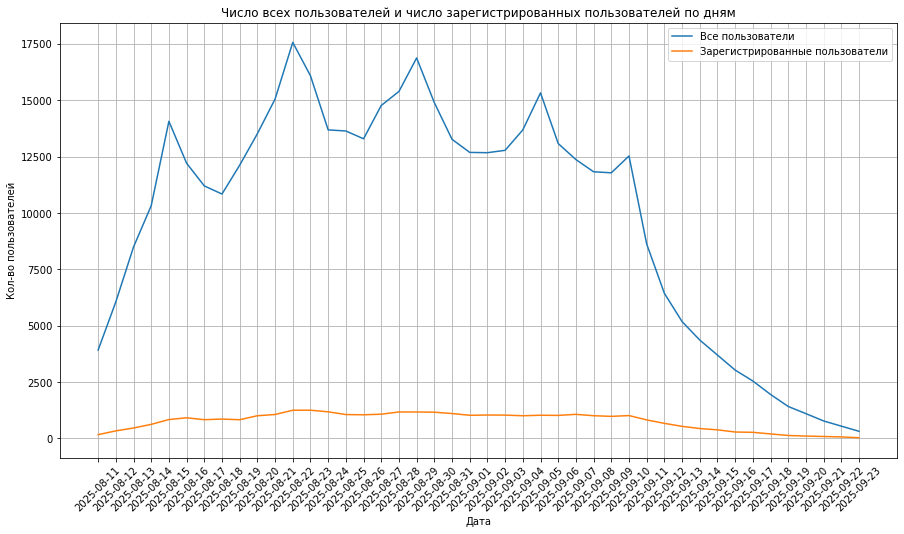

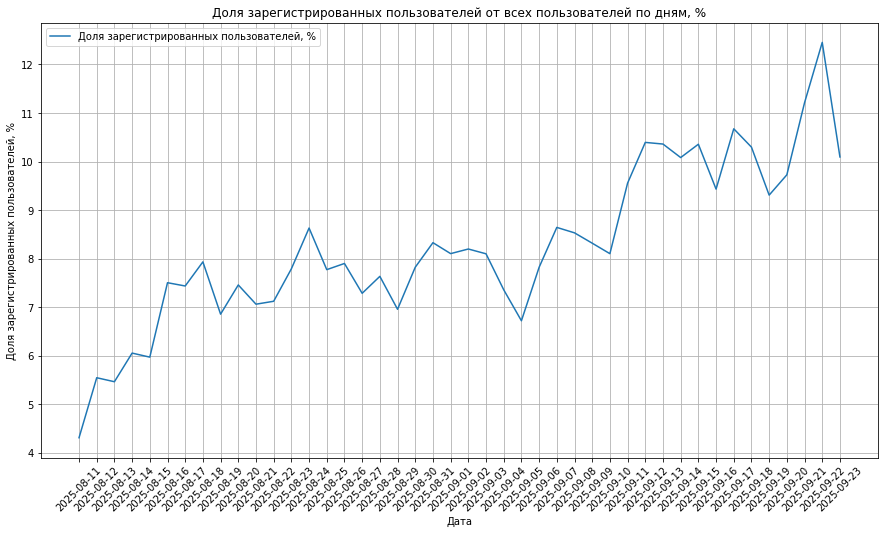

In [5]:
# Агрегируем исторические данные по пользователеям для каждого дня
gr_history = sessions_history.groupby(['user_id', 'session_date'], as_index=False )\
                             .agg(count_user = ('user_id', 'count'), max_registr_flag = ('registration_flag', 'max'))\
                             .sort_values(by='session_date', ascending=False) 

# Число уникальных пользователей для каждого дня
users_all = gr_history.groupby('session_date')['user_id'].count()
# Число зарегистрированных пользователей для каждого дня
users_reg = gr_history[gr_history['max_registr_flag']==1].groupby('session_date')['user_id'].count()

# Задаём размер графика
plt.figure(figsize=(15, 8))

# Строим линейный график для всех пользователей
plt.plot(users_all, label='Все пользователи')
# Строим линейный график для зарегистрированных пользователей
plt.plot(users_reg, label='Зарегистрированные пользователи')

# Настраиваем оформление графика
plt.xticks(rotation=45) # поворот подписей оси Х
plt.grid() # линии сетки
plt.xlabel('Дата')
plt.ylabel('Кол-во пользователей')
plt.legend()
plt.title('Число всех пользователей и число зарегистрированных пользователей по дням')
# Выводим график
plt.show()

# Считаем доли зарегистрированных пользователей от всех пользователей по дням
users_reg_share = 100*users_reg/users_all

# Задаём размер графика
plt.figure(figsize=(15, 8))

# Строим линейный график доли зарегистрированных пользователей от всех пользователей по дням
plt.plot(users_reg_share, label='Доля зарегистрированных пользователей, %')

# Настраиваем оформление графика
plt.xticks(rotation=45)
plt.grid()
plt.xlabel('Дата')
plt.ylabel('Доля зарегистрированных пользователей, %')
plt.legend()
plt.title('Доля зарегистрированных пользователей от всех пользователей по дням, %')
# Выводим график
plt.show()

Выводы:   
- можно отметить, что количество пользователей росло начиная с начала июня. Затем наблюдаем пилообразные всплески с 7ми дневным интервалом до начала сентября,возможно вызванные повышением активности пользователей в выходные дни и  резкое падение с начала сентября. Динамика числа зарегистрированных пользователей  по дням в общем повторяет динамику числа всех пользователей, но носит более плавный характер не повторяя резких всплесков.
- важно отметить тренд роста доли зарегистрированных пользователей в течение всего периода

#### 1.4. Анализ числа просмотренных страниц
Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы, что он зарегистрируется и оплатит подписку.

- Найдём количество сессий для каждого значения количества просмотренных страниц. 

- Построим столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.


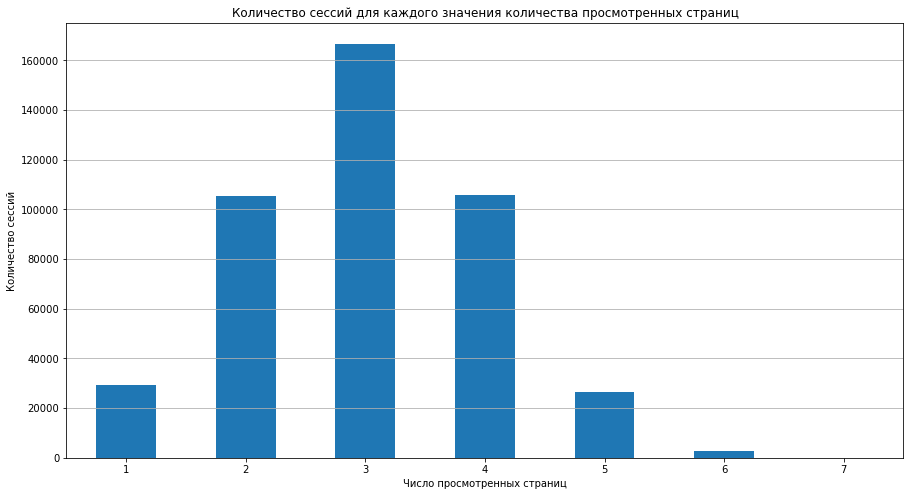

In [6]:
# Находим количество сессий для каждого значения количества просмотренных страниц
session_count = sessions_history.groupby('page_counter')['session_id'].count()
session_count

# Определим размер графика
plt.figure(figsize=(15, 8))

# Строим столбчатый график
session_count.plot(
         kind='bar',
         rot = 0)

# Настраиваем оформление графика
plt.xlabel('Число просмотренных страниц')
plt.ylabel('Количество сессий')
plt.grid(axis='y')
plt.title('Количество сессий для каждого значения количества просмотренных страниц')
# Выводим график
plt.show()

Выводы:  
- Из графика видно, что чаще всего пользователи просмотривают 3 страницы. График ности характер нормального симметричного распределения

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создадим дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Построим график со средним значением доли успешных сессий от всех сессий по дням за весь период наблюдения.

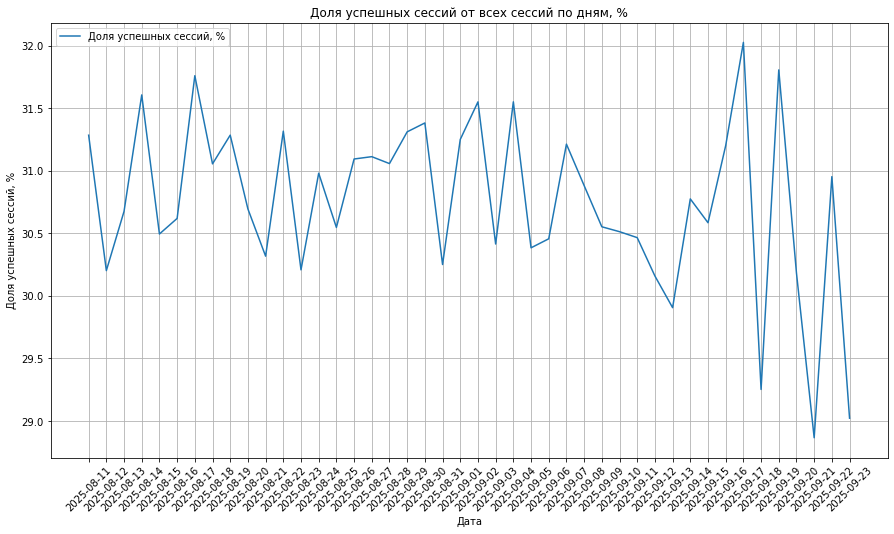

In [7]:
# Ссоздаём дополнительный столбец good_session со значением 1, если за одну сессию было просмотрено 4 и более страниц
sessions_history['good_session'] = np.where(sessions_history['page_counter'] >= 4,  1, 0)

# Считаем количество успешных сессий по дням
gr_good_session = sessions_history.groupby('session_date')['good_session'].sum()
# Считаем количество всех сессий по дням
gr_all_session = sessions_history.groupby('session_date')['session_id'].count()
# Определяем долю успешных сессий от всех сессий по дням
share_good_session = 100*gr_good_session / gr_all_session

# Определим размер графика
plt.figure(figsize=(15, 8))

# Строим линейный график
plt.plot(share_good_session, 
         label='Доля успешных сессий, %')
plt.xticks(rotation=45)

# Настраиваем оформление графика
plt.grid()
plt.xlabel('Дата')
plt.ylabel('Доля успешных сессий, %')
plt.legend()
plt.title('Доля успешных сессий от всех сессий по дням, %')
# Выводим график
plt.show()

Выводы:  
- динамика доли успешных сессий (с просмотром 4х и более страниц) несмотря на пилообразный вид в среднем постоянна до начала сентября с дальнейшим понижающим трендом

### 2. Подготовка к тесту


#### 2.1 Формулировка нулевой и альтернативной гипотез

Изначальное условие: команда разработчиков рекомендательных систем создала новый алгоритм, который, по их мнению, будет показывать более интересный контент для каждого пользователя.




Сформулируем нулевую и альтернативную гипотезы:  

- Метрика - количество хороших сессий, в течение которых пользователь просмотрит 4 и более страниц приложения

- Нулевая гипотеза :
    - H₀: доля успешных сессий в тестовой группе B меньше или равна, чем в контрольной группе A.
- Альтернативная гипотеза :
    - H₁: доля успешных сессий в тестовой группе B больше, чем в контрольной группе A.







#### 2.2. Расчёт размера выборки


In [ ]:
# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Вероятность ошибки второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
p1 = 0.3 # Базовый уровень доли
mde = 0.03 * p1  # Минимальный детектируемый эффект 3%
effect_size = proportion_effectsize(p1, p1 + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


#### 2.3. Расчёт длительности A/B-теста


In [9]:
# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = sessions_history.groupby('session_date')['user_id'].count().mean()


# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = ceil(sample_size*2 / avg_daily_users )

print(f"Рассчитанная длительность A/B-теста при текущем уровене трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

Рассчитанная длительность A/B-теста при текущем уровене трафика в 9907.363636363636 пользователей в день составит 9 дней


<!-- ✅⚠️⛔❌🚩 -->


Важно понимать, что это допустимый минимальный срок, однако для повышения надёжности результатов теста желательно провести его дольше , чтобы сгладить возможные колебания в поведении пользователей по дням недели и собрать больше данных для анализа.       
В нашем случае тест длится - 20 дней, за счёт чего общее число участников увеличивается. Поэтому мощность теста остаётся высокой — 99.97%. Это значит, что вероятность не заметить реальный эффект крайне мала.   

### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитаем и выведем на экран процентную разницу в количестве пользователей в группах A и B. 

Для расчёта процентной разницы воспользуемся формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [10]:
# Считаем и сохраним в датафрейм sessions_test_part CSV-файл с историческими данными о сессиях пользователей
sessions_test_part = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test_part.csv')
# display(sessions_test_part.head(5))

# Выводим два датафрейма для группы А и группы В
test_part_A = sessions_test_part[sessions_test_part.test_group == 'A']
test_part_B = sessions_test_part[sessions_test_part.test_group == 'B']


# Рассчитаем количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения
users_a_count = test_part_A['user_id'].nunique()
users_b_count = test_part_B['user_id'].nunique()
print('Кол-во уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения')
print(f'группа А: {users_a_count}, группа В: {users_b_count}\n')

# Рассчитаем процентную разницу в количестве пользователей в группах A и B
diff = 100*abs(users_a_count - users_b_count) / users_a_count
print(f'Разница в количестве пользователей в группах A и B,: {round(diff, 2)} % ')


Кол-во уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения
группа А: 1477, группа В: 1466

Разница в количестве пользователей в группах A и B,: 0.74 % 


- разницу количества пользователей двух групп менее 1% можно считать не существенной

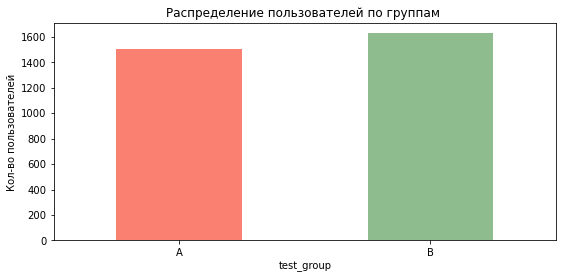

In [11]:
# Группируем пользователей по группам А/В
gr_test_part = sessions_test_part.groupby('test_group')['user_id'].count()

# Строим диаграмму распределения пользователей по группа А/В
gr_test_part.plot(kind='bar',
                  rot=0,
                  color=['salmon', 'darkseagreen'],#'yellowgreen'
                  figsize=(9, 4))#labels=('Группа А', 'Группа В')
            
# Настраиваем оформление графика
plt.title("Распределение пользователей по группам ")
plt.ylabel('Кол-во пользователей')
# Отображаем график
plt.show() 

Выводы:  
- распределение кол-ва пользователей равномерно. Разницу количества между двух групп менее 1% можно считать не существенной

#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах, убедимся в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитаем количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [12]:
# Пользователи группы А
users_a = sessions_test_part[sessions_test_part.test_group == 'A']['user_id']
# Пользователи группы В
users_b = sessions_test_part[sessions_test_part.test_group == 'B']['user_id']

# Рассчитаем количество пользователей, которые встречаются одновременно в группах A и B
interselection = len(list(set(users_a) & set(users_b)))
print(f'Кол-во пользователей, которые встречаются одновременно в группах A и B: {interselection}')

Кол-во пользователей, которые встречаются одновременно в группах A и B: 0


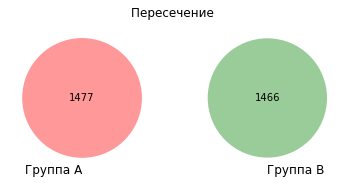

In [13]:
A = set(sessions_test_part[sessions_test_part.test_group == 'A']['user_id'].unique())
B = set(sessions_test_part[sessions_test_part.test_group == 'B']['user_id'].unique())

# Строим диаграмму Венна
venn2([A, B], set_labels=('Группа А', 'Группа В'))

# Отображаем график
plt.title("Пересечение ")
plt.show() 



Выводы:  
- диаграмма Венна показывает полную независимость и отсутсвие пересечений двух групп между собой, т.е. пользователи одной группы не попадают на другую

#### 3.3. Равномерность разделения пользователей по устройствам
Убедимся в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройств и регионам.

Построим две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.


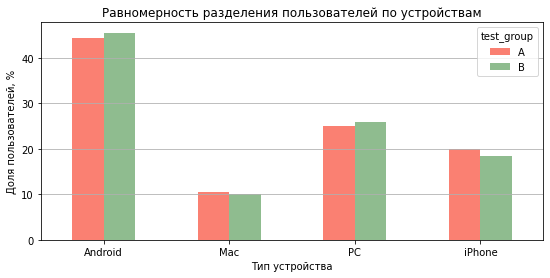

In [14]:
# Оставляем уникальные значения user_id
uniq_region = sessions_test_part[['device', 'test_group', 'user_id']].drop_duplicates(subset='user_id')
# Группируем уникальных пользователей по устройству
gr_uniq_region = uniq_region.groupby(['device', 'test_group'], as_index=False)['user_id'].count()
# Добавляем столбец с расчетом доли
gr_uniq_region['share'] = 100*gr_uniq_region['user_id']/gr_uniq_region.groupby('test_group')['user_id'].transform('sum')
# Группируем кол-во пользователей по типу устройства для тестовых групп
device_test_part = pd.pivot_table(gr_uniq_region, values='share', index='device',
                       columns=['test_group'], aggfunc="sum") 

# Строим столбчатый график
device_test_part.plot(kind='bar',
                      figsize=(9, 4),
                      rot=0,
                      color=['salmon', 'darkseagreen'])
# Настраиваем оформление графика
plt.grid(axis='y')
plt.xlabel('Тип устройства')
plt.ylabel('Доля пользователей, %')
plt.title('Равномерность разделения пользователей по устройствам')
# Отображаем график
plt.show()

Выводы:  
- несмотря на несущественные разницы по устройствам можно заключить, что распределение пользователей по группам равномерно и является репрезентативным

#### 3.4. Равномерность распределения пользователей по регионам
Убедимся, что пользователи равномерно распределены по регионам.

Построим две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.


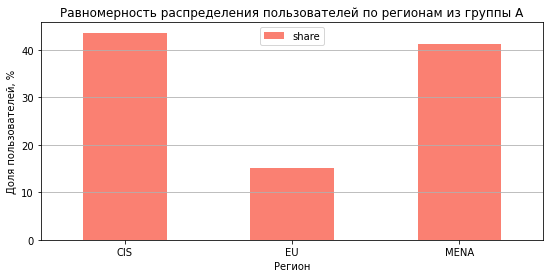

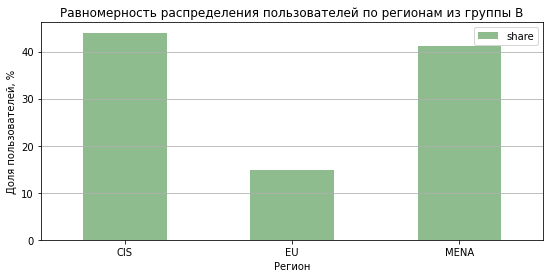

In [15]:
# Определяем уникальные значения user_id для группы А
uniq_region_A = test_part_A[['region', 'test_group', 'user_id']].drop_duplicates(subset='user_id')
# Группируем уникальных пользователей по региону
gr_uniq_region_A = uniq_region_A.groupby(['region', 'test_group'], as_index=False)['user_id'].count()
# Добавляем столбец с расчетом доли
gr_uniq_region_A['share'] = 100*gr_uniq_region_A['user_id']/gr_uniq_region_A.groupby('test_group')['user_id'].transform('sum')

# Определяем уникальные значения user_id для группы В
uniq_region_B = test_part_B[['region', 'test_group', 'user_id']].drop_duplicates(subset='user_id')
# Группируем уникальных пользователей по устройству
gr_uniq_region_B = uniq_region_B.groupby(['region', 'test_group'], as_index=False)['user_id'].count()
# Добавляем столбец с расчетом доли
gr_uniq_region_B['share'] = 100*gr_uniq_region_B['user_id']/gr_uniq_region_B.groupby('test_group')['user_id'].transform('sum')


# Строим график распределения для группы А
gr_uniq_region_A[['region', 'share']].plot( kind='bar',
                         x='region',
                         rot=0,
                         color='salmon',#'yellowgreen'
                         figsize=(9, 4))
# Настраиваем оформление графика
plt.grid(axis='y')
plt.xlabel('Регион')
plt.ylabel('Доля пользователей, %')
plt.title('Равномерность распределения пользователей по регионам из группы A')
# Отображаем график
plt.show()

# # Строим график распределения для группы В
gr_uniq_region_B[['region', 'share']].plot( kind='bar',
                         x='region',
                         rot=0,
                         color='darkseagreen',#'yellowgreen'
                         figsize=(9, 4))
# Настраиваем оформление графика
plt.grid(axis='y')
plt.xlabel('Регион')
plt.ylabel('Доля пользователей, %')
plt.title('Равномерность распределения пользователей по регионам из группы В')
# Отображаем график
plt.show()

Выводы:  
- характер графиков распределение пользователей по регионам носит схожий характер. Данные по регионам распределены равномерно. 

#### 3.5. Вывод после проверки A/B-теста


Выводы на основе проведённого анализа A/B-теста:  
- Обнаруженое различие в количестве пользователей в двух группах незначительно 
- Пересечение пользователей из тестовой и контрольной групп не обнаружено  
- Распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам можно считать равномерным

### 4. Проверка результатов A/B-теста


#### 4.1. Получение результатов теста и подсчёт основной метрики


In [ ]:
# # Выгружаем и сохраняем в датафрейм данные тестирования
sessions_test = pd.read_csv('https://code.s3.yandex.net/datasets/sessions_project_test.csv')


# Ссоздаём дополнительный столбец good_session со значением 1, если за одну сессию было просмотрено 4 и более страниц и значение 0, если просмотрено меньше
sessions_test['good_session'] = np.where(sessions_test['page_counter'] >= 4,  1, 0)
sessions_test.head(5)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


#### 4.2. Проверка корректности результатов теста


- Рассчитаем количество уникальных сессий для каждого дня и обеих тестовых групп.

- Проверим, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми. Используем статистический тест, который позволит сделать вывод о равенстве средних двух выборок.


Проверяем следующие гипотизы:  
- H₀ (нулевая гипотеза) — количество уникальных дневных сессий не различается между тестовой и контрольной группами.
- H₁ (альтернативная гипотеза) — количество уникальных дневных сессий различается между тестовой и контрольной группами.

In [17]:
# Считаем количество сессий по дням для группы А
session_test_A = sessions_test[sessions_test['test_group']=='A'].groupby('session_date')['session_id'].count()
# Считаем количество сессий по дням для группы В
session_test_B = sessions_test[sessions_test['test_group']=='B'].groupby('session_date')['session_id'].count()


alpha = 0.05 ## на каком уровне значимости проверяем гипотезу о равенстве выборочных средних
stat_ttest, p_value_ttest = ttest_ind(
    session_test_A, 
    session_test_B, 
    alternative='two-sided' ) 

if p_value_ttest>alpha:
    print(f'p-value теста Стьюдента ={round(p_value_ttest, 2)}')
    print('H₀ (нулевая гипотеза) — количество уникальных дневных сессий не различается между тестовой и контрольной группами.')
else:
    print(f'p-value теста Стьюдента ={round(p_value_ttest, 2)}')
    print('H₁ (альтернативная гипотеза) — количество уникальных дневных сессий различается между тестовой и контрольной группами.')


p-value теста Стьюдента =0.94
H₀ (нулевая гипотеза) — количество уникальных дневных сессий не различается между тестовой и контрольной группами.


#### 4.3. Сравнение доли успешных сессий


In [18]:
# Считаем количество успешных сессий по дням для группы А
good_session_test_A = sessions_test[sessions_test['test_group']=='A']['good_session'].sum()
# Считаем количество всех сессий по дням для группы А
all_session_test_A = sessions_test[sessions_test['test_group']=='A']['session_id'].count()
# Определяем долю успешных сессий от всех сессий по дням для группы А
share_good_session_A = 100*good_session_test_A / all_session_test_A
print(f'Доля успешных сессий для группы A: {share_good_session_A}%')

# Считаем количество успешных сессий по дням для группы B
good_session_test_B = sessions_test[sessions_test['test_group']=='B']['good_session'].sum()
# Считаем количество всех сессий по дням для группы B
all_session_test_B = sessions_test[sessions_test['test_group']=='B']['session_id'].count()
# Определяем долю успешных сессий от всех сессий по дням для группы B
share_good_session_B = 100*good_session_test_B / all_session_test_B
print(f'Доля успешных сессий для группы B: {share_good_session_B}%')

# Разница доли успешных скссий в группах А и В
diff = abs(share_good_session_A - share_good_session_B)
print(f'Разница доли успешных скссий в группах А и В : {diff}%')


Доля успешных сессий для группы A: 30.772335573449578%
Доля успешных сессий для группы B: 31.828992745867524%
Разница доли успешных скссий в группах А и В : 1.056657172417946%


<div 

 
Если доля успешных сессий в одной из групп выше, это может говорить о том, что изменения, протестированные в этой группе, положительно повлияли на пользовательский опыт. А значит, они могут быть внедрены в основную версию продукта.

#### 4.4. Насколько статистически значимо изменение ключевой метрики

Количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитаем, является ли изменение в метрике доли успешных сессий статистически значимым.

In [19]:
alpha =  0.05 

# Проведем Z-тест пропорций
stat_ztest, p_value_ztest = proportions_ztest( 
    [good_session_test_A, good_session_test_B],
    [all_session_test_A, all_session_test_B],
    alternative='larger')

print(f'pvalue={p_value_ztest}')

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=0.9998425260011964
pvalue=0.9998425260011964 > 0.05
Нулевая гипотеза находит подтверждение!


#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:

- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.

- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.

- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

- Стоит ли внедрять нововведение в приложение.

####    Выводы на основе проведённого анализа результатов теста:  
- для проведёния эксперимента было задействованно 30579 пользователей. Длительность эксперимента составила 9 дней
- внедрение нового алгоритма рекомендаций не повлияло на рост ключевой метрики  
- значение p-value для оценки статистической значимости выявленного эффекта составило 0.0003  
